In [413]:
import math

import pandas as pd
from nltk.stem import SnowballStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [415]:
stemmer = SnowballStemmer('english')

In [416]:
tdf_g = pd.read_csv('speaker_grouped.csv')

In [336]:
tdf_g

,Unnamed: 0,date,speaker,text_enhanced,tokens
2027,2027,1994-02-04,CHAIRMAN GREENSPAN.,"As you know, this is our organizational meetin...","[know, organiz, meet, alway, meet, elect, chai..."
2028,2028,1994-02-04,MR. BERNARD.,"Secretary and Economist, Donald Kohn; Deputy S...","[secretari, economist, donald, kohn, deputi, s..."
2029,2029,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development...","[normal, econom, expans, develop, real, sector..."
2030,2030,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...,"[report, go, pretti, bland, develop, sinc, dec..."
2031,2031,1994-02-04,MR. COYNE.,"Oh, believe me, you will get asked! I think i...","[oh, believ, get, ask, think, take, coupl, min..."
...,...,...,...,...,...
7804,7804,2017-12-13,MS. BRAINARD.,I don't think of this as a normative statement...,"[n't, think, norm, statement, think, forecast,..."
7805,7805,2017-12-13,MS. GEORGE.,"Lorie, on exhibit 2, chart 12, would you expla...","[lori, exhibit, 2, chart, 12, would, explain, ..."
7806,7806,2017-12-13,MS. LOGAN.,Thank you. I will begin on your second exhibi...,"[thank, begin, second, exhibit, discuss, money..."
7807,7807,2017-12-13,MS. MESTER.,"Thank you, Madam Chair. Reports received from...","[thank, madam, chair, report, receiv, contact,..."


In [417]:
tdf_g = tdf_g[pd.to_datetime(tdf_g['date']).dt.year >= 1994]

In [418]:
tdf_g['tokens'] = tdf_g['text_enhanced'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [419]:
texts = tdf_g['tokens'].tolist()

In [420]:
dictionary = Dictionary(texts)

In [421]:
unfiltered_corpus = [dictionary.doc2bow(text) for text in texts]

In [422]:
len(dictionary)

28158

In [424]:
count = 0

freqs = {}
doc_appears = {}

for text in texts:
    for token, freq in dictionary.doc2bow(text):
        if token in freqs:
            freqs[token] += freq
        else:
            freqs[token] = freq
        if token in doc_appears:
            doc_appears[token] += 1
        else:
            doc_appears[token] = 1
    count +=1

{0: 16436, 1: 5004, 2: 10394, 3: 54030, 4: 36956, 5: 29, 6: 14, 7: 178, 8: 234, 9: 213, 10: 115, 11: 4170, 12: 920, 13: 1932, 14: 49, 15: 12, 16: 213, 17: 410, 18: 5, 19: 41, 20: 75, 21: 29, 22: 11, 23: 43, 24: 74, 25: 437, 26: 7573, 27: 199, 28: 141, 29: 15, 30: 2164, 31: 3980, 32: 1, 33: 52, 34: 2889, 35: 2753, 36: 1947, 37: 1, 38: 81, 39: 16084, 40: 150, 41: 1539, 42: 2253, 43: 206, 44: 2667, 45: 1311, 46: 3911, 47: 115, 48: 3404, 49: 568, 50: 1511, 51: 5114, 52: 7069, 53: 8072, 54: 1592, 55: 2383, 56: 5555, 57: 193, 58: 4594, 59: 2839, 60: 324, 61: 367, 62: 2488, 63: 2878, 64: 5016, 65: 1101, 66: 2213, 67: 267, 68: 2016, 69: 16469, 70: 1864, 71: 260, 72: 3337, 73: 2008, 74: 3601, 75: 4507, 76: 2283, 77: 4186, 78: 36, 79: 540, 80: 2067, 81: 389, 82: 175, 83: 4, 84: 4437, 85: 151, 86: 943, 87: 4011, 88: 1815, 89: 1711, 90: 7215, 91: 528, 92: 4213, 93: 102, 94: 2575, 95: 3445, 96: 721, 97: 234, 98: 1684, 99: 4142, 100: 64, 101: 1346, 102: 599, 103: 1800, 104: 99, 105: 8786, 106: 1497,

In [426]:
idf = {i: math.log(len(texts) / doc_appears[i]) for i in range(len(dictionary))}

In [428]:
tfidf_global = {i: idf[i] * (1 + math.log(freqs[i])) for i in range(len(dictionary))}

In [429]:
tfidf_vals = sorted([rank for rank in tfidf_global.values()], reverse=True)

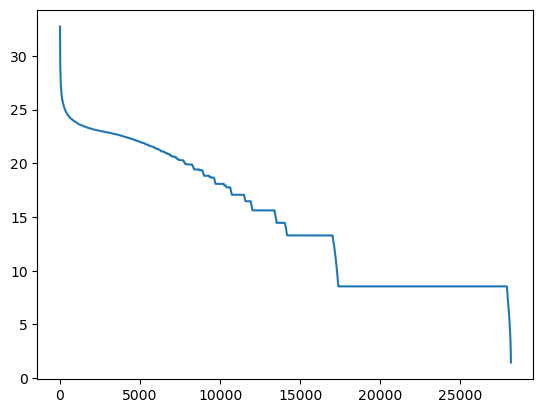

In [430]:
plt.plot(tfidf_vals)

In [431]:
tokens_to_keep = [i for i, tfidf in tfidf_global.items() if tfidf > tfidf_vals[13000]]
len(tokens_to_keep)

12017

In [432]:
dictionary.filter_tokens(good_ids=tokens_to_keep)
dictionary.compactify()
len(dictionary)

In [433]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [434]:
K = 45

In [435]:
ldamodel = LdaModel(corpus, num_topics=K, id2word=dictionary, passes=5, random_state=0, minimum_probability=0, eta=0.025, alpha=50/K)

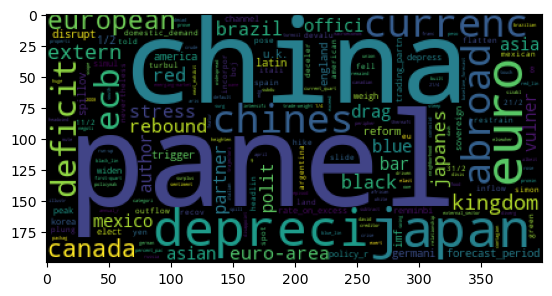

In [459]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(22, 200))))

In [ ]:
for i in range(45):
    print(nmf.show_topic(i, 10)[0:5])
    print('\n')

In [ ]:
def get_max_topic(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    if len(topic_probs) > 0:
        max_prob = topic_probs[0][1]
        max_ind = 0
        for i in range(1, len(topic_probs)):
            if topic_probs[i][1] > max_prob:
                max_prob = topic_probs[i][1]
                max_ind = i
        return pd.Series([topic_probs[max_ind][0], max_prob], index=['topic', 'prob'])
    return pd.Series([None, None], index=['topic', 'prob'])

In [18]:
def get_all_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    result = [0] * 45
    for topic, prob in topic_probs:
        result[topic] = prob
    return pd.Series(result)

In [56]:
tdf_g[[f'tprob_{i}' for i in range(45)]] = tdf_g.tokens.apply(get_all_topics)

In [472]:
tdf_sample = tdf.sample(5000)

In [473]:
tdf_sample[['topic','topic_prob']] = tdf_sample.tokens.apply(get_topics)

In [479]:
tdf_sample[tdf_sample['topic'] == 5][['content', 'topic_prob']].to_csv('topictest.csv')

In [209]:
path = "Loughran-McDonald_MasterDictionary_1993-2021.csv"

lm_df = pd.read_csv(path)

lm = {}

for i, row in lm_df.iterrows():
    # print(row)
    word = str(row['Word']).lower()
    if row['Negative'] != 0:
        lm[word] = -1
    if row['Positive'] != 0:
        lm[word] = 1

In [219]:
def sentscore(string):
    # tokens = process(string)
    total = 0
    tokens = [token.lower() for token in word_tokenize(str(string))]
    numtokens = len(tokens) if len(tokens) > 0 else 1
    for token in tokens:
        # print(token)
        if token in lm:
            total += lm[token]
            # print(token)
            # print(lm[token])
    # print(total)
    # print(tokens)
    return total